# Categorizing Memo Data

## Imports and Packages

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import re
import nltk
from nltk.corpus import stopwords
import string
import os
import nltk

2024-02-08 21:41:56.641800: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.version.cuda, device)

11.8 cuda:0


## Preprocessing

In [5]:
inflows = pd.read_parquet('data/q2_inflows_final.pqt')
outflows = pd.concat([ 
    pd.read_parquet('data/q2_outflows_1sthalf_final.pqt'),
    pd.read_parquet('data/q2_outflows_2ndhalf_final.pqt')
])


In [6]:
account = pd.read_parquet('data/q2_acctDF_final.pqt')
nota = pd.read_parquet('data/q2_consDF_final.pqt')

In [7]:
print("outflows")
outflows.head() 

outflows


,prism_consumer_id,prism_account_id,memo_clean,amount,posted_date,category_description
62,0,acc_0,Online Transfer to CHK ...XXXX transaction#: X...,280.00,2023-01-06,SELF_TRANSFER
63,0,acc_0,PAYPAL INST XFER RAINBOW WEB ID: PAYPALSI77,47.83,2022-07-21,EXTERNAL_TRANSFER
64,0,acc_0,Online Transfer to CHK ...XXXX transaction#: X...,280.00,2022-12-12,SELF_TRANSFER
65,0,acc_0,Online Transfer to CHK ...XXXX transaction#: X...,300.00,2022-12-09,SELF_TRANSFER
66,0,acc_0,Online Transfer to CHK ...XXXX transaction#: X...,500.00,2023-02-17,SELF_TRANSFER


In [8]:
print("account information")
account 

account information


,prism_consumer_id,prism_account_id,account_type,balance,balance_date
0,0,acc_0,SAVINGS,6182.60,2023-04-13
1,0,acc_1,CHECKING,9907.23,2023-04-13
2,2,acc_12,SAVINGS,17426.83,2022-02-15
3,2,acc_11,CHECKING,8079.43,2022-02-15
4,4,acc_16,SAVINGS,0.00,2021-08-13
...,...,...,...,...,...
4691,5941,acc_9478,CHECKING,2058.81,2023-01-06
4692,5943,acc_9480,CHECKING,2431.44,2023-02-02
4693,5944,acc_9481,CHECKING,45.74,2023-02-01
4694,5945,acc_9482,CHECKING,59.88,2023-02-01


In [9]:
print('account type')
account['account_type'].value_counts()

account type


account_type
CHECKING           3688
SAVINGS             771
CREDIT CARD         221
MONEY MARKET         13
PREPAID               1
CD                    1
CASH MANAGEMENT       1
Name: count, dtype: int64

In [13]:
inflows['category_description'].unique()

array(['SELF_TRANSFER', 'INVESTMENT_INCOME', 'DEPOSIT', 'REFUND',
       'PAYCHECK_PLACEHOLDER', 'EXTERNAL_TRANSFER', 'MISCELLANEOUS',
       'TAX', 'PAYCHECK', 'SMALL_DOLLAR_ADVANCE', 'LOAN',
       'OTHER_BENEFITS', 'INSURANCE', 'UNEMPLOYMENT_BENEFITS'],
      dtype=object)

In [14]:
outflows['category_description'].unique() 

array(['SELF_TRANSFER', 'EXTERNAL_TRANSFER', 'ATM_CASH', 'ACCOUNT_FEES',
       'GROCERIES', 'GENERAL_MERCHANDISE', 'LOAN', 'GIFTS_DONATIONS',
       'CREDIT_CARD_PAYMENT', 'FOOD_AND_BEVERAGES', 'AUTOMOTIVE',
       'INSURANCE', 'ENTERTAINMENT', 'ESSENTIAL_SERVICES',
       'HEALTHCARE_MEDICAL', 'UNCATEGORIZED', 'TRAVEL',
       'HOME_IMPROVEMENT', 'PETS', 'OVERDRAFT', 'TAX', 'BNPL', 'RENT',
       'EDUCATION', 'MORTGAGE', 'CHILD_DEPENDENTS', 'PAYCHECK',
       'BILLS_UTILITIES'], dtype=object)

In [12]:
inflows[inflows['prism_account_id']=='acc_87'].sort_values(by='posted_date')

,prism_consumer_id,prism_account_id,memo_clean,amount,posted_date,category_description
16959,26,acc_87,Online payment from CHK XXXX,282.05,2021-01-25,MISCELLANEOUS
16960,26,acc_87,Online payment from CHK XXXX,128.74,2021-03-02,MISCELLANEOUS
16956,26,acc_87,Online payment from CHK XXXX,166.80,2021-04-06,MISCELLANEOUS
16961,26,acc_87,Online payment from CHK XXXX,166.80,2021-05-19,MISCELLANEOUS
16955,26,acc_87,Online payment from CHK XXXX,286.16,2021-06-29,MISCELLANEOUS
16962,26,acc_87,Online payment from CHK XXXX,152.50,2021-08-03,MISCELLANEOUS
16957,26,acc_87,Online payment from CHK XXXX,303.99,2021-09-28,MISCELLANEOUS
16958,26,acc_87,Online payment from CHK XXXX,927.14,2021-11-24,MISCELLANEOUS


In [13]:
account[account['account_type']=="CREDIT CARD"]

,prism_consumer_id,prism_account_id,account_type,balance,balance_date
7,7,acc_24,CREDIT CARD,7071.18,2021-08-08
42,26,acc_87,CREDIT CARD,0.00,2021-12-17
43,26,acc_86,CREDIT CARD,0.00,2021-12-17
44,26,acc_85,CREDIT CARD,1230.53,2021-12-17
51,29,acc_94,CREDIT CARD,7345.67,2021-11-08
...,...,...,...,...,...
2674,1959,acc_5431,CREDIT CARD,11815.57,2021-09-01
2679,1961,acc_5435,CREDIT CARD,13000.00,2022-02-21
2712,1993,acc_5524,CREDIT CARD,0.00,2023-04-13
2714,1993,acc_5523,CREDIT CARD,732.01,2023-04-13


In [14]:
nota['FPF_TARGET'].value_counts()

FPF_TARGET
0.0    2417
1.0     561
Name: count, dtype: int64

## Merge the inflow and outflow as total

In [15]:
out = outflows.copy()
out['amount'] = outflows['amount'].apply(lambda x: -x)
total = inflows._append(out, ignore_index=True)



# FPF_Target Prediction

In [16]:
#feature 1 
#total consumption for each individual
consumption = outflows.groupby('prism_consumer_id')['amount'].sum().sort_index()

In [17]:
#feature 3 
#total consumption on entertainment
enter = outflows[outflows['category_description'] == 'ENTERTAINMENT']
enter_feature = enter.groupby('prism_consumer_id')['amount'].sum().sort_values().sort_index()
f3 = enter_feature.to_frame().merge(nota['FPF_TARGET'].to_frame(), left_index=True, right_index=True, how = 'right')
f3 = f3.fillna(0)

In [100]:
#feature 5
#consumption / income 
#entertainment / income 
f5 = f3['amount'] / consumption.reset_index()['amount']
f5 = f5.fillna(0)

In [41]:
def cate(flows, category):
    enter = flows[flows['category_description'] == category]
    enter_feature = enter.groupby('prism_consumer_id')['amount'].sum().sort_values().sort_index()
    f3 = enter_feature.to_frame().merge(nota['FPF_TARGET'].to_frame(), left_index=True, right_index=True, how = 'right')
    f3 = f3.fillna(0)
    return f3['amount']

In [44]:

t = cate(outflows,'RENT' ) / consumption.reset_index()['amount']
t = t.fillna(0)


In [112]:
modelTest(t.to_frame(), nota['FPF_TARGET'])

[0. 0. 0. ... 0. 0. 0.]
0.0
Precision: 0.0
Recall: 0.0
accuracy_score: 0.8112416107382551
roc_auc_score:0.5


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0)

In [21]:
total['month'] = total['posted_date'].apply(lambda x: x.month)


In [22]:
total['year'] = total['posted_date'].apply(lambda x: x.year)

In [23]:
total['year'].unique()

array([2022, 2023, 2021, 2020, 2018, 2019])

In [24]:
consumption_month = total.groupby(['prism_consumer_id','year', 'month'])['amount'].sum().to_frame()

In [62]:
blank = consumption_month.copy()
blank.loc[:, :] = 0
blank = blank.unstack(level=['year', 'month']).fillna(0)

In [25]:
temp = consumption_month.unstack(level=['year', 'month'])
temp = temp.fillna(0)


In [58]:
t = total[total['category_description'] == 'RENT'].groupby(['prism_consumer_id','year', 'month'])['amount'].sum().to_frame()
t.unstack(level=['year', 'month']).fillna(0)

amount                                               \
year                  2022                                2021     2020   
month                   5        6        7        9        6        11   
prism_consumer_id                                                         
9                 -2375.24 -2375.24 -2375.24 -4757.00     0.00     0.00   
13                    0.00     0.00     0.00     0.00   -30.26     0.00   
16                    0.00     0.00     0.00     0.00     0.00 -2686.26   
25                    0.00     0.00     0.00     0.00     0.00     0.00   
26                    0.00     0.00     0.00     0.00  -410.00     0.00   
...                    ...      ...      ...      ...      ...      ...   
5861               -400.00  -800.00 -1415.00     0.00 -2945.00     0.00   
5871              -1436.28 -1434.24 -1456.63 -1535.48     0.00     0.00   
5892                  0.00  -874.19  -875.00  -902.91     0.00     0.00   
5926                  0.00     0.00     0.00  -508.00     0.00     0.00   
5930                 -1.95    -1.95    -1.95    -1.95     0.00     0.00   

                                                     ...                      \
year                           2021     2022   2021  ... 2023 2020             
month                   12       7        12     1   ...   4    7    8    3    
prism_consumer_id                                    ...                       
9                     0.00     0.00     0.00    0.0  ...  0.0  0.0  0.0  0.0   
13                    0.00     0.00     0.00    0.0  ...  0.0  0.0  0.0  0.0   
16                -1647.56   -73.66     0.00    0.0  ...  0.0  0.0  0.0  0.0   
25                    0.00     0.00  -548.00    0.0  ...  0.0  0.0  0.0  0.0   
26                    0.00  -410.00     0.00 -410.0  ...  0.0  0.0  0.0  0.0   
...                    ...      ...      ...    ...  ...  ...  ...  ...  ...   
5861                  0.00 -2130.00     0.00    0.0  ...  0.0  0.0  0.0  0.0   
5871                  0.00     0.00 -1513.38    0.0  ...  0.0  0.0  0.0  0.0   
5892                  0.00     0.00     0.00    0.0  ...  0.0  0.0  0.0  0.0   
5926                  0.00     0.00  -596.09    0.0  ...  0.0  0.0  0.0  0.0   
5930                  0.00     0.00    -2.95    0.0  ...  0.0  0.0  0.0  0.0   

                                                 
year                                  2023       
month               4    5    6    2    6    7   
prism_consumer_id                                
9                  0.0  0.0  0.0  0.0  0.0  0.0  
13                 0.0  0.0  0.0  0.0  0.0  0.0  
16                 0.0  0.0  0.0  0.0  0.0  0.0  
25                 0.0  0.0  0.0  0.0  0.0  0.0  
26                 0.0  0.0  0.0  0.0  0.0  0.0  
...                ...  ...  ...  ...  ...  ...  
5861               0.0  0.0  0.0  0.0  0.0  0.0  
5871               0.0  0.0  0.0  0.0  0.0  0.0  
5892               0.0  0.0  0.0  0.0  0.0  0.0  
5926               0.0  0.0  0.0  0.0  0.0  0.0  
5930               0.0  0.0  0.0  0.0  0.0  0.0  

[473 rows x 42 columns]

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score

def modelTest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
    clf = LogisticRegression(random_state=0,C=0.5).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    score = roc_auc_score(y_test, y_pred)
    print(y_pred.mean())
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"accuracy_score: {accuracy_score(y_test, y_pred)}") 
    print(f"roc_auc_score:{score}")
    return precision, recall
    

In [139]:
#calculate the monthly consumption on given cateogry 
def month_consump(flows, cate):
    total['month'] = total['posted_date'].apply(lambda x: x.month)
    total['year'] = total['posted_date'].apply(lambda x: x.year)
    consumption_month = total.groupby(['prism_consumer_id','year', 'month'])['amount'].sum().to_frame()
    blank = consumption_month.copy()
    blank.loc[:, :] = 0
    blank = blank.unstack(level=['year', 'month']).fillna(0)
    cate_flows = flows[flows['category_description'] == cate]
    cate_flows['month'] = cate_flows['posted_date'].apply(lambda x: x.month)
    cate_flows['year'] = cate_flows['posted_date'].apply(lambda x: x.year)
    cate_consump = cate_flows.groupby(['prism_consumer_id','year', 'month'])['amount'].sum().to_frame()
    temp = cate_consump.unstack(level=['year', 'month'])
    temp = temp.fillna(0)
    return temp.combine_first(blank[temp.columns])
   


In [69]:
r = month_consump(outflows, 'RENT')
#r.merge(blank, left_index=True, right_index=True, how = 'left')
r

/tmp/ipykernel_106/211621672.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total['month'] = total['posted_date'].apply(lambda x: x.month)
/tmp/ipykernel_106/211621672.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total['year'] = total['posted_date'].apply(lambda x: x.year)


amount                                               \
year                  2022                                2021     2020   
month                   5        6        7        9        6        11   
prism_consumer_id                                                         
9                  2375.24  2375.24  2375.24  4757.00     0.00     0.00   
13                    0.00     0.00     0.00     0.00    30.26     0.00   
16                    0.00     0.00     0.00     0.00     0.00  2686.26   
25                    0.00     0.00     0.00     0.00     0.00     0.00   
26                    0.00     0.00     0.00     0.00   410.00     0.00   
...                    ...      ...      ...      ...      ...      ...   
5861                400.00   800.00  1415.00     0.00  2945.00     0.00   
5871               1436.28  1434.24  1456.63  1535.48     0.00     0.00   
5892                  0.00   874.19   875.00   902.91     0.00     0.00   
5926                  0.00     0.00     0.00   508.00     0.00     0.00   
5930                  1.95     1.95     1.95     1.95     0.00     0.00   

                                                     ...                      \
year                           2021     2022   2021  ... 2023 2020             
month                   12       7        12     1   ...   4    7    8    3    
prism_consumer_id                                    ...                       
9                     0.00     0.00     0.00    0.0  ...  0.0  0.0  0.0  0.0   
13                    0.00     0.00     0.00    0.0  ...  0.0  0.0  0.0  0.0   
16                 1647.56    73.66     0.00    0.0  ...  0.0  0.0  0.0  0.0   
25                    0.00     0.00   548.00    0.0  ...  0.0  0.0  0.0  0.0   
26                    0.00   410.00     0.00  410.0  ...  0.0  0.0  0.0  0.0   
...                    ...      ...      ...    ...  ...  ...  ...  ...  ...   
5861                  0.00  2130.00     0.00    0.0  ...  0.0  0.0  0.0  0.0   
5871                  0.00     0.00  1513.38    0.0  ...  0.0  0.0  0.0  0.0   
5892                  0.00     0.00     0.00    0.0  ...  0.0  0.0  0.0  0.0   
5926                  0.00     0.00   596.09    0.0  ...  0.0  0.0  0.0  0.0   
5930                  0.00     0.00     2.95    0.0  ...  0.0  0.0  0.0  0.0   

                                                 
year                                  2023       
month               4    5    6    2    6    7   
prism_consumer_id                                
9                  0.0  0.0  0.0  0.0  0.0  0.0  
13                 0.0  0.0  0.0  0.0  0.0  0.0  
16                 0.0  0.0  0.0  0.0  0.0  0.0  
25                 0.0  0.0  0.0  0.0  0.0  0.0  
26                 0.0  0.0  0.0  0.0  0.0  0.0  
...                ...  ...  ...  ...  ...  ...  
5861               0.0  0.0  0.0  0.0  0.0  0.0  
5871               0.0  0.0  0.0  0.0  0.0  0.0  
5892               0.0  0.0  0.0  0.0  0.0  0.0  
5926               0.0  0.0  0.0  0.0  0.0  0.0  
5930               0.0  0.0  0.0  0.0  0.0  0.0  

[473 rows x 42 columns]

In [29]:
# new features
# mean difference per category ; 1 num for each feature 
# standard diviation for monthly spend ; 1 num for each feature 
# monthly consumption on each category over 


In [149]:
modelTest(month_consump(inflows, 'DEPOSIT'), nota['FPF_TARGET'])

/tmp/ipykernel_106/2254478954.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cate_flows['month'] = cate_flows['posted_date'].apply(lambda x: x.month)
/tmp/ipykernel_106/2254478954.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cate_flows['year'] = cate_flows['posted_date'].apply(lambda x: x.year)


[0. 0. 0. ... 0. 0. 0.]
0.04194630872483222
Precision: 0.38
Recall: 0.08444444444444445
accuracy_score: 0.8011744966442953
roc_auc_score:0.5261932666896473


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.38, 0.08444444444444445)

In [52]:
netIncome = total.groupby('prism_consumer_id')['amount'].sum().sort_values().sort_index()
netIncome 

prism_consumer_id
0       15029.73
2         292.27
4        3330.82
7        7231.32
9        5841.63
          ...   
5941    -1517.55
5943     2405.10
5944      -48.23
5945    -3114.74
5949      253.76
Name: amount, Length: 2978, dtype: float64

In [53]:
trans_count = inflows.groupby('prism_consumer_id')['prism_account_id'].count()

In [55]:

#account['amount'].apply(lambda x: if -x)
account.loc[account['account_type'] == 'CREDIT CARD', 'balance'] *= -1 
f2 = account.groupby('prism_consumer_id')['balance'].sum().sort_index()

In [56]:
f2.to_frame()

,balance
prism_consumer_id,
0,16089.83
2,25506.26
4,5521.39
7,-5975.01
9,13348.76
...,...
5941,2058.81
5943,2431.44
5944,45.74


In [57]:
f2

prism_consumer_id
0       16089.83
2       25506.26
4        5521.39
7       -5975.01
9       13348.76
          ...   
5941     2058.81
5943     2431.44
5944       45.74
5945       59.88
5949     1112.01
Name: balance, Length: 2978, dtype: float64

In [58]:
f2_ = (f2-f2.min())/(f2.max()-f2.min())
f2_

prism_consumer_id
0       0.076372
2       0.090375
4       0.060656
7       0.043560
9       0.072296
          ...   
5941    0.055507
5943    0.056061
5944    0.052514
5945    0.052535
5949    0.054099
Name: balance, Length: 2978, dtype: float64

In [69]:
modelTest(f2_.to_frame(), nota['FPF_TARGET'])

[0. 0. 0. ... 0. 0. 0.]
0.0
Precision: 0.0
Recall: 0.0
accuracy_score: 0.8112416107382551
roc_auc_score:0.5


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0)

In [68]:
modelTest(netIncome.to_frame(), nota['FPF_TARGET']) 

[1. 1. 1. ... 1. 1. 0.]
0.5318791946308725
Precision: 0.21293375394321767
Recall: 0.6
accuracy_score: 0.5058724832214765
roc_auc_score:0.5419855222337124


(0.21293375394321767, 0.6)

In [67]:
modelTest(trans_count.to_frame(), nota['FPF_TARGET'])

[0. 0. 0. ... 0. 0. 0.]
0.0
Precision: 0.0
Recall: 0.0
accuracy_score: 0.8112416107382551
roc_auc_score:0.5


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0)

In [104]:
modelTest(temp, nota['FPF_TARGET'])

[0. 0. 1. ... 0. 0. 0.]
0.33808724832214765
Precision: 0.18362282878411912
Recall: 0.3288888888888889
accuracy_score: 0.5973154362416108
roc_auc_score:0.49433069056647133


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.18362282878411912, 0.3288888888888889)

In [61]:
modelTest(f3['amount'].to_frame(), nota['FPF_TARGET'])

[0. 0. 0. ... 0. 0. 0.]
0.0
Precision: 0.0
Recall: 0.0
accuracy_score: 0.8112416107382551
roc_auc_score:0.5


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0)

In [ ]:
outflows['amount'].apply(lambda x: -x) 

In [65]:
testLst = [consumption, netIncome, trans_count]

In [44]:
f2.describe()

count      2978.000000
mean       5718.009261
std       27023.113121
min      -35267.920000
25%          43.117500
50%         464.435000
75%        2355.382500
max      637198.200000
Name: balance, dtype: float64

(array([2.866e+03, 8.500e+01, 1.300e+01, 5.000e+00, 3.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([-35267.92 ,  31978.692,  99225.304, 166471.916, 233718.528,
        300965.14 , 368211.752, 435458.364, 502704.976, 569951.588,
        637198.2  ]),
 <BarContainer object of 10 artists>)

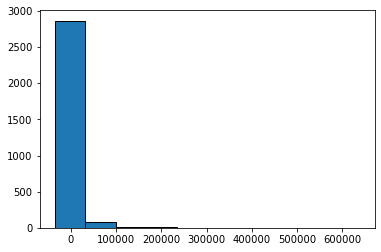

In [46]:
plt.hist(f2, bins=10, edgecolor='black')

In [7]:
inflows['memo']

0                METROPOLITAN REG PAYROLL PPD ID: XXXXXXXXXX
1          METROPOLITAN REG VENDOR XXXXXX CCD ID: XXXXXXXXXX
2                       ONSTAR SERVICES 888-4ONSTAR MI 08/25
3          Zelle payment from CHRISTOPHER J LYONS XXXXXXX...
4          METROPOLITAN REG VENDOR XXXXXX CCD ID: XXXXXXXXXX
                                 ...                        
1035832    POS DEPOSITUber 182 Howard St. San Francisco C...
1035833    POS DEPOSITUber 182 Howard St. San Francisco C...
1035834    ACH DEPOSIT RAISER XXXXTYPE: EDI PAYMNT DATA: ...
1035835    POS DEPOSITUber 182 Howard St. San Francisco C...
1035836    POS DEPOSITUber 182 Howard St. San Francisco C...
Name: memo, Length: 513115, dtype: object

In [20]:

print("Inflow memo after preprocessing")
inflows['memo'].head()

Inflow memo after preprocessing


0       metropolitan reg payroll ppd id
1        metropolitan reg vendor ccd id
2    onstar services 8884onstar mi 0825
3     zelle payment christopher j lyons
4        metropolitan reg vendor ccd id
Name: memo, dtype: object

In [15]:
#inflows.groupby(posted_date).count()
outflows['posted_date'].sort_values()

1500469    2017-12-29
1500123    2017-12-29
1499938    2018-01-02
1500677    2018-01-02
1499814    2018-01-03
              ...    
2639606    2023-08-01
2639014    2023-08-01
2443520    2023-08-01
2895180    2023-08-01
2895221    2023-08-01
Name: posted_date, Length: 2597488, dtype: object

# EDA

## Customer Analysis

In [23]:
print('Income Souce Rank by Amount')
inflows.groupby('category')['amount'].sum().sort_values(ascending=False).to_frame()

Income Souce Rank by Amount


,amount
category,
EXTERNAL_TRANSFER,81586232.14
DEPOSIT,66602343.60
PAYCHECK,54018520.29
MISCELLANEOUS,52594312.59
SELF_TRANSFER,48301522.92
PAYCHECK_PLACEHOLDER,35706161.73
OTHER_BENEFITS,12175837.46
INVESTMENT_INCOME,6887278.35
TAX,5619601.78


Income Souce Rank by Amount


<AxesSubplot:ylabel='amount'>

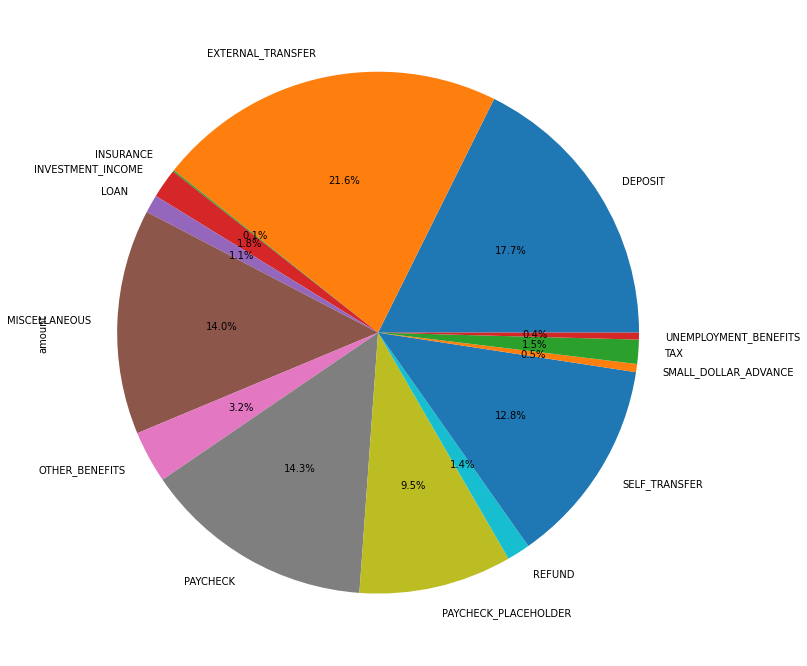

In [22]:
print('Income Souce Rank by Amount')
data = inflows.groupby('category')['amount'].sum()

data.plot.pie(autopct='%1.1f%%', figsize=(12, 12))

In [20]:
print('Customer Income Statsitics ')
income = inflows.groupby('prism_consumer_id')['amount'].sum()
income

Customer Income Statsitics 


prism_consumer_id
0       110312.43
2       349639.03
4       462557.90
7       250214.09
9       215342.01
          ...    
5930    127177.11
5935     13640.13
5939     33882.65
5940     67452.46
5941     58633.91
Name: amount, Length: 2974, dtype: float64

In [21]:
income.describe()

count    2.974000e+03
mean     1.267604e+05
std      3.005366e+05
min      2.400000e-01
25%      2.589696e+04
50%      5.684713e+04
75%      1.353733e+05
max      1.032516e+07
Name: amount, dtype: float64

In [27]:
print('count of transactions per consumer ')
trans_count = inflows.groupby('prism_consumer_id')['prism_account_id'].count()
df = trans_count.describe().to_frame()
df.rename(columns = {'prism_account_id':'transaction'}, inplace = True) 
df

count of transactions per consumer 


,transaction
count,2974.000000
mean,172.533625
std,148.452108
min,1.000000
25%,78.000000
50%,134.000000
75%,219.000000
max,1765.000000


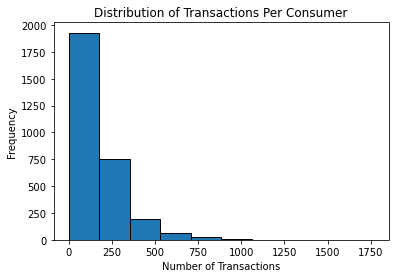

In [49]:
plt.hist(trans_count, bins=10, edgecolor='black')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.title('Distribution of Transactions Per Consumer')
plt.show()

In [28]:
#customer spending statsitics 
consumption = outflows.groupby('prism_consumer_id')['amount'].sum()
consumption.describe().to_frame()

,amount
count,2.968000e+03
mean,1.270095e+05
std,2.966008e+05
min,2.400000e-01
25%,2.617188e+04
50%,5.720956e+04
75%,1.371515e+05
max,1.015039e+07


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


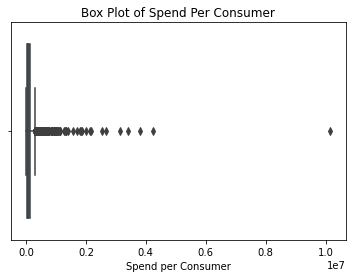

In [51]:
sns.boxplot(consumption)
plt.xlabel('Spend per Consumer')
plt.title('Box Plot of Spend Per Consumer')
plt.show()

In [19]:
out = outflows.copy()
out['amount'] = outflows['amount'].apply(lambda x: -x)


In [20]:
out

,prism_consumer_id,prism_account_id,memo_clean,amount,posted_date,category_description
62,0,acc_0,Online Transfer to CHK ...XXXX transaction#: X...,-280.00,2023-01-06,SELF_TRANSFER
63,0,acc_0,PAYPAL INST XFER RAINBOW WEB ID: PAYPALSI77,-47.83,2022-07-21,EXTERNAL_TRANSFER
64,0,acc_0,Online Transfer to CHK ...XXXX transaction#: X...,-280.00,2022-12-12,SELF_TRANSFER
65,0,acc_0,Online Transfer to CHK ...XXXX transaction#: X...,-300.00,2022-12-09,SELF_TRANSFER
66,0,acc_0,Online Transfer to CHK ...XXXX transaction#: X...,-500.00,2023-02-17,SELF_TRANSFER
...,...,...,...,...,...,...
3084767,3997,acc_7534,Cenex F U Oil,-16.93,2023-06-07,AUTOMOTIVE
3084768,3997,acc_7534,Cenex F U Oil,-20.72,2023-06-14,AUTOMOTIVE
3084769,3997,acc_7534,Reserveit Park/Shower,-25.00,2023-04-08,HOME_IMPROVEMENT
3084770,3997,acc_7534,Metapay*Cathy Szydlo,-220.00,2023-04-11,EXTERNAL_TRANSFER


In [21]:
total = inflows._append(out, ignore_index=True)

In [22]:
print('Customer Net Income')
netIncome = total.groupby('prism_consumer_id')['amount'].sum().sort_values()
netIncome

Customer Net Income


prism_consumer_id
949    -1492984.18
1896    -642879.04
831     -364780.55
824     -361927.09
25      -329442.81
           ...    
1720     239537.81
1890     240190.83
555      311125.03
456      404781.67
197      575143.92
Name: amount, Length: 2978, dtype: float64

In [35]:
print('Net Income Stats')
netIncome.describe().to_frame()

Net Income Stats


,amount
count,2.978000e+03
mean,-8.078926e+02
std,3.923504e+04
min,-1.492984e+06
25%,-6.191825e+02
50%,3.064500e+01
75%,7.476775e+02
max,5.751439e+05


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4fd5165d-30f2-4024-858c-b9c44fc2581b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>